# Clasificación de datos texto

Reseñas de Netlix



## Analisis exploratorio de los datos


In [2]:
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
df_net = pd.read_csv('netflix_reviews.csv')

In [4]:
df_net.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,604f0c0a-6d7b-4651-b9f0-054b9ab0fb7c,QJ Golding,"New plan doesn't support chromecast, doesn't e...",1,0,8.118.1 build 10 50703,2024-06-11 22:02:54,8.118.1 build 10 50703
1,25c73759-f688-40bd-bd51-73f8242fb86a,Carolyn K Davis,"I enjoy the content that Netflix brings, but w...",4,0,8.109.0 build 7 50647,2024-06-11 22:01:14,8.109.0 build 7 50647
2,51daa77d-7d2a-4479-a7b7-698aa294bebd,Hailey Adrielle Apostol,when I try to play something it won't play and...,1,0,8.118.1 build 10 50703,2024-06-11 21:55:52,8.118.1 build 10 50703
3,3b1484d7-8564-4489-a78c-087f00d0259c,Mohammad Hafizz,Bodo punya netflix....,1,0,8.118.1 build 10 50703,2024-06-11 21:52:38,8.118.1 build 10 50703
4,4675eb67-63b0-4afc-a4ca-5d32ce3f5d49,Jeffrey Rich,Just superb👌,5,0,8.117.0 build 3 50695,2024-06-11 21:43:43,8.117.0 build 3 50695


In [5]:
# consideramos las columnas necesarias
df_net = df_net[['content','score']]

In [6]:
df_net.head()

,content,score
0,"New plan doesn't support chromecast, doesn't e...",1
1,"I enjoy the content that Netflix brings, but w...",4
2,when I try to play something it won't play and...,1
3,Bodo punya netflix....,1
4,Just superb👌,5


In [7]:
# crearemos una clasificacion para score que si menor o igual a 3 es negativo y si es mayor a 3 positivo
df_net['clasificacion'] = df_net['score'].apply(lambda x: 'positivo' if x > 3 else 'negativo')

In [8]:
df_net.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112568 entries, 0 to 112567
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   content        112566 non-null  object
 1   score          112568 non-null  int64 
 2   clasificacion  112568 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.6+ MB


## Visualización de los datos

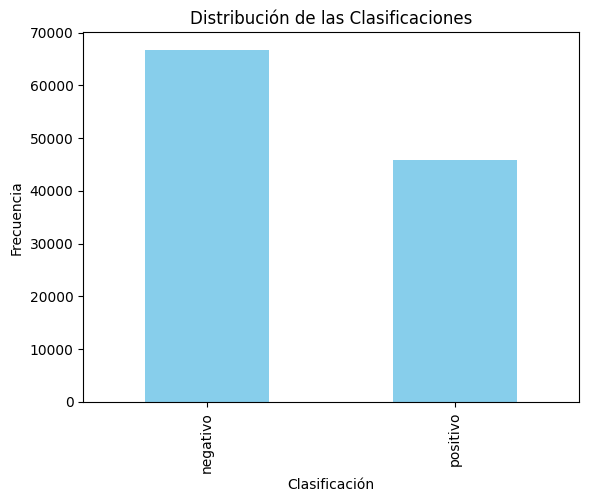

In [9]:
# distribución de las clasificaciones

df_net['clasificacion'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribución de las Clasificaciones')
plt.xlabel('Clasificación')
plt.ylabel('Frecuencia')
plt.show()


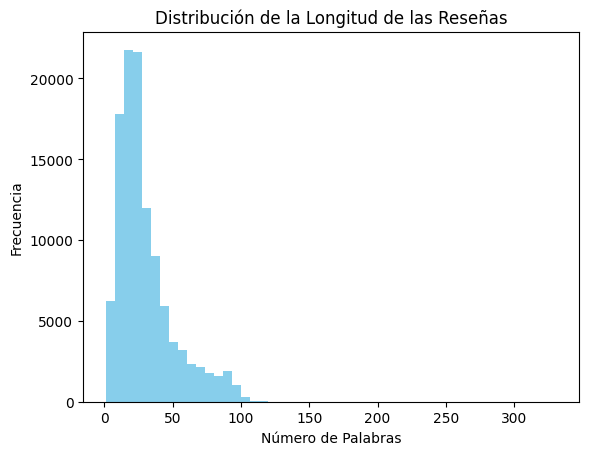

In [10]:
#distribución de número de palabras y la frecuencia de las reseñas

df_net['review_length'] = df_net['content'].apply(lambda x: len(str(x).split()))
df_net['review_length'].plot(kind='hist', bins=50, color='skyblue')
plt.title('Distribución de la Longitud de las Reseñas')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.show()

## Preprocesamiento de datos

In [11]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [12]:
# preprocesamiento del texto, eliminamos, limpiamos, tokenizamos, lematizamos
def preprocess_text(text):
    # Manejamos valores que no son cadenas de texto y regresamos cadenas vacias
    if not isinstance(text, (str, bytes)):
        return ""

    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# aplicamos
df_net['cleaned_content'] = df_net['content'].apply(preprocess_text)

In [13]:
print(df_net[['content', 'cleaned_content', 'clasificacion']].head())

                                             content  \
0  New plan doesn't support chromecast, doesn't e...   
1  I enjoy the content that Netflix brings, but w...   
2  when I try to play something it won't play and...   
3                             Bodo punya netflix....   
4                                       Just superb👌   

                                     cleaned_content clasificacion  
0  new plan support chromecast even notify user f...      negativo  
1  enjoy content netflix brings rate increased w ...      positivo  
2  try play something play say loading hour first...      negativo  
3                                 bodo punya netflix      negativo  
4                                             superb      positivo  


## Modelos, vectores y resultados.

### Entrenamiento y prueba

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [16]:
# Dividimos los datos en conjuntos de entrenamiento y prueba 80 y 20
X = df_net['cleaned_content']
y = df_net['clasificacion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# vectorización
vectorizers = {
    "Count n-grams": CountVectorizer(ngram_range=(2, 3)),
    "TF-IDF": TfidfVectorizer(),
    "TF-IDF n-grams": TfidfVectorizer(ngram_range=(2, 3))
}


In [18]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
}

In [19]:
# Entrenamiento y evaluación
results = []

for vec_name, vectorizer in vectorizers.items():
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    for model_name, model in models.items():
        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_test_vec)

        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)

        results.append({
            "Model": model_name,
            "Vectorizer": vec_name,
            "Accuracy": accuracy,
            "Report": report,
            "Confusion Matrix": cm
        })

In [20]:

for result in results:
    print(f"Model: {result['Model']} with {result['Vectorizer']}")
    print("Accuracy:", result["Accuracy"])
    df_report = pd.DataFrame(result["Report"]).transpose()
    print(df_report)
    print("\n" + "="*80 + "\n")

Model: Logistic Regression with Count n-grams
Accuracy: 0.8230878564448787
              precision    recall  f1-score       support
negativo       0.833900  0.877972  0.855369  13415.000000
positivo       0.804887  0.742169  0.772257   9099.000000
accuracy       0.823088  0.823088  0.823088      0.823088
macro avg      0.819393  0.810071  0.813813  22514.000000
weighted avg   0.822174  0.823088  0.821779  22514.000000


Model: Random Forest with Count n-grams
Accuracy: 0.5958514701963223
              precision    recall  f1-score       support
negativo       0.595851  1.000000  0.746751  13415.000000
positivo       0.000000  0.000000  0.000000   9099.000000
accuracy       0.595851  0.595851  0.595851      0.595851
macro avg      0.297926  0.500000  0.373375  22514.000000
weighted avg   0.355039  0.595851  0.444952  22514.000000


Model: Logistic Regression with TF-IDF
Accuracy: 0.8643510704450564
              precision    recall  f1-score       support
negativo       0.866139  0.913

In [21]:
# Obtener las predicciones del mejor modelo
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

best_model = LogisticRegression(C=1.0, solver='liblinear')
best_model.fit(X_train_vec, y_train)
y_pred = best_model.predict(X_test_vec)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)


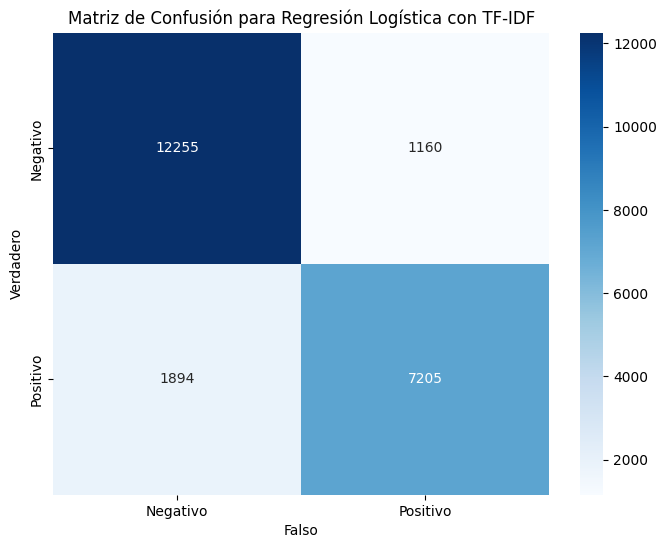

In [23]:

# Mostrar matriz de confusión como mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión para Regresión Logística con TF-IDF')
plt.xlabel('Falso')
plt.ylabel('Verdadero')
plt.show()


## Modelos hiperparametros ajustados

In [22]:
# Modelos con hiperparámetros ajustados
lr_params = {
    'C': 0.5,
    'solver': 'liblinear'
}

rf_params = {
    'n_estimators': 200,
    'max_depth': 20,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'random_state': 42
}

models_adjusted = {
    "Logistic Regression (Adjusted)": LogisticRegression(**lr_params),
    "Random Forest (Adjusted)": RandomForestClassifier(**rf_params)
}


In [23]:
# Combinar ambos diccionarios de modelos
models.update(models_adjusted)


In [24]:
# Entrenamiento y evaluación
results = []

for vec_name, vectorizer in vectorizers.items():
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    for model_name, model in models.items():
        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_test_vec)

        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)

        results.append({
            "Model": model_name,
            "Vectorizer": vec_name,
            "Accuracy": accuracy,
            "Report": report,
            "Confusion Matrix": cm
        })

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

In [26]:
# Mostrar resultados en tablas
for result in results:
    print(f"Model: {result['Model']} with {result['Vectorizer']}")
    print("Accuracy:", result["Accuracy"])
    df_report = pd.DataFrame(result["Report"]).transpose()
    print(df_report)
    print("\n" + "="*80 + "\n")

Model: Logistic Regression with Count n-grams
Accuracy: 0.8230878564448787
              precision    recall  f1-score       support
negativo       0.833900  0.877972  0.855369  13415.000000
positivo       0.804887  0.742169  0.772257   9099.000000
accuracy       0.823088  0.823088  0.823088      0.823088
macro avg      0.819393  0.810071  0.813813  22514.000000
weighted avg   0.822174  0.823088  0.821779  22514.000000


Model: Random Forest with Count n-grams
Accuracy: 0.5958514701963223
              precision    recall  f1-score       support
negativo       0.595851  1.000000  0.746751  13415.000000
positivo       0.000000  0.000000  0.000000   9099.000000
accuracy       0.595851  0.595851  0.595851      0.595851
macro avg      0.297926  0.500000  0.373375  22514.000000
weighted avg   0.355039  0.595851  0.444952  22514.000000


Model: Logistic Regression (Adjusted) with Count n-grams
Accuracy: 0.8235764413253975
              precision    recall  f1-score       support
negativo    

In [27]:
# Vectorización y entrenamiento del mejor modelo ajustado
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

best_model = LogisticRegression(C=0.5, solver='liblinear')
best_model.fit(X_train_vec, y_train)
y_pred = best_model.predict(X_test_vec)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

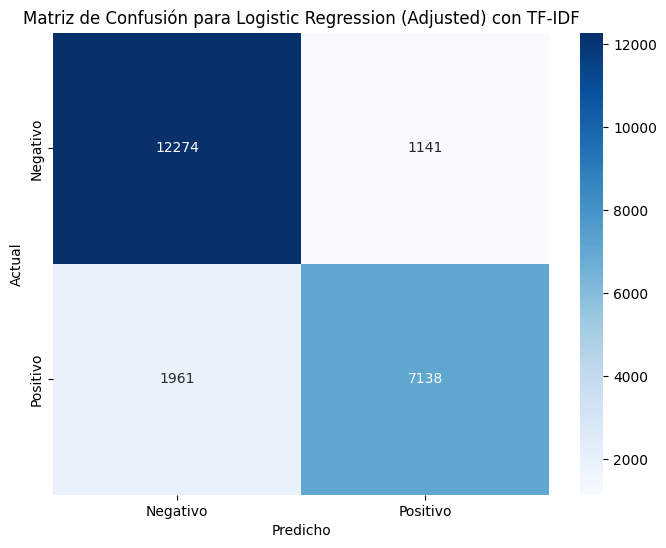

In [28]:
# Mostrar matriz de confusión como mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión para Logistic Regression (Adjusted) con TF-IDF')
plt.xlabel('Predicho')
plt.ylabel('Actual')
plt.show()